Optimal Number of Clusters: 2
DB Index for Optimal Clusters: 0.9326276410648637


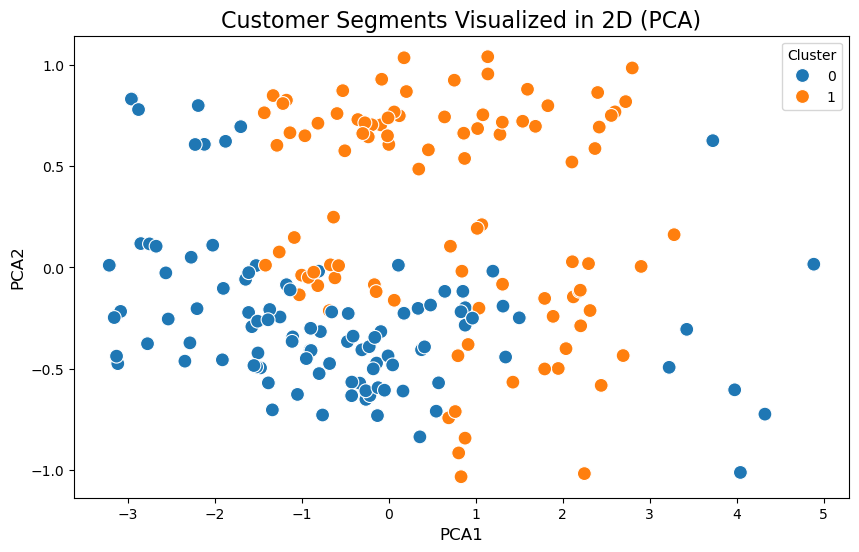

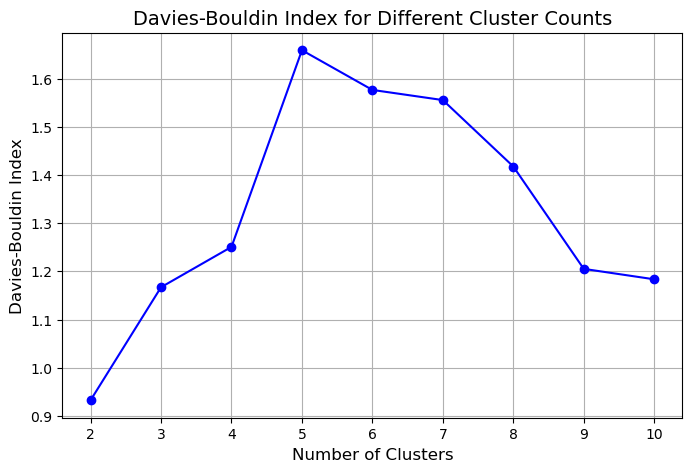

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets
df = transactions.merge(customers, on='CustomerID')

# Feature Engineering
df['TotalSpent'] = df['Quantity'] * df['Price']
customer_features = df.groupby('CustomerID').agg({
    'TotalSpent': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'count',
    'Region': lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown',
    'SignupDate': lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days
}).reset_index()

# One-hot encode categorical variables
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
numerical_cols = ['TotalSpent', 'Quantity', 'TransactionID', 'SignupDate']
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Choose number of clusters (2 to 10)
db_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(customer_features.iloc[:, 1:])
    
    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_features.iloc[:, 1:-1], customer_features['Cluster'])
    db_scores.append(db_index)

# Find the optimal number of clusters (lowest DB Index)
optimal_clusters = cluster_range[np.argmin(db_scores)]
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clusters: {min(db_scores)}")

# Perform final clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features.iloc[:, 1:])

# Visualize Clusters (Using PCA for dimensionality reduction)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_features.iloc[:, 1:-1])
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('Customer Segments Visualized in 2D (PCA)', fontsize=16)
plt.xlabel('PCA1', fontsize=12)
plt.ylabel('PCA2', fontsize=12)
plt.legend(title='Cluster')
plt.show()

# Save clustering results
customer_features.to_csv('Customer_Segments.csv', index=False)

# Plot DB Index for different numbers of clusters
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, db_scores, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Cluster Counts', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Davies-Bouldin Index', fontsize=12)
plt.xticks(cluster_range)
plt.grid()
plt.show()
